In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm_notebook as tqdm

import os

import random

from transformers import BertTokenizerFast, BertModel
import torch

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture

import pyconll

from spacy_conll import init_parser

In [2]:
import spacy
from spacy.lang.en.examples import sentences 

nlp = spacy.load("en_core_web_sm")
doc = nlp(sentences[0])
print(doc.text)
for token in doc:
    print(token.text, token.pos_, token.dep_)

Apple is looking at buying U.K. startup for $1 billion
Apple PROPN nsubj
is AUX aux
looking VERB ROOT
at ADP prep
buying VERB pcomp
U.K. PROPN nsubj
startup VERB ccomp
for ADP prep
$ SYM quantmod
1 NUM compound
billion NUM pobj


In [3]:
model_name = "bert-base-uncased"

tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.device

device(type='cuda', index=0)

In [4]:
conll = pyconll.load.load_from_file("en_sample.conllu")
conll = conll[0]
text = conll.text
text

'I didn’t mean to sound mean when I asked what your word mean.'

In [5]:
def get_token_embeddings(
    text: str,
    model: BertModel,
    tokenizer: BertTokenizerFast
):
    """
    入力英語テキストを WordPiece トークンごとにエンコードし、
    最後の隠れ層を返す。
    """

    device = model.device

    inputs = tokenizer(
        text,
        return_tensors="pt",
        return_attention_mask=True,
        add_special_tokens=True
    )
# トークナイズ（offset_mapping を取りたい）
    encoding = tokenizer(
        text,
        return_tensors="pt",
        return_offsets_mapping=True,
        add_special_tokens=True
    )
    # word_ids を先に取り出す
    word_ids = encoding.word_ids()

    # モデル入力用に不要キーを除去＆デバイスへ転送
    model_inputs = {
        k: v.to(device)
        for k, v in encoding.items()
        if k in ("input_ids", "attention_mask", "token_type_ids")
    }

    # フォワード実行
    with torch.no_grad():
        outputs = model(**model_inputs)

    hidden_states = outputs.last_hidden_state.squeeze(0)
    tokens        = tokenizer.convert_ids_to_tokens(model_inputs["input_ids"].squeeze(0))

    return tokens[1:-1], hidden_states[1:-1], word_ids[1:-1] # 最初と最後の [CLS] と [SEP] トークンを除去

In [6]:
tokens, hidden_states, word_ids = get_token_embeddings(text, model, tokenizer)

In [7]:
tokens, hidden_states, word_ids

(['i',
  'didn',
  '’',
  't',
  'mean',
  'to',
  'sound',
  'mean',
  'when',
  'i',
  'asked',
  'what',
  'your',
  'word',
  'mean',
  '.'],
 tensor([[ 0.4578,  0.1025, -0.9234,  ...,  0.0477,  0.2282,  0.8160],
         [ 0.2374,  0.2965, -0.7695,  ...,  0.1801, -0.3717,  0.2093],
         [ 0.7907, -0.1881,  0.5255,  ..., -0.1920, -0.9502, -0.4241],
         ...,
         [ 1.0181,  0.3002, -0.6165,  ...,  0.0284, -0.1584,  0.3770],
         [ 0.4481,  0.4183,  0.1496,  ..., -0.9412, -0.1584,  0.2252],
         [ 0.7145,  0.1388, -0.6122,  ...,  0.3809, -0.4362, -0.4026]],
        device='cuda:0'),
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

In [8]:
mean_ids = [idx for idx, token in enumerate(tokens) if token=="mean"]
mean_ids

[4, 7, 14]

In [9]:
mean_embeddings = hidden_states[mean_ids, :].cpu().detach().numpy()


In [10]:
mean1 = mean_embeddings[0]
mean2 = mean_embeddings[1]
mean3 = mean_embeddings[2]

In [11]:
cosine_similarity(mean_embeddings)

array([[1.        , 0.43157426, 0.3265652 ],
       [0.43157426, 1.0000004 , 0.44222754],
       [0.3265652 , 0.44222754, 0.99999976]], dtype=float32)

In [12]:
embeddings = {}
for idx, token, emb in zip(word_ids, tokens, hidden_states):
    if token in embeddings.keys():
        embeddings[token].append(emb.cpu().detach().numpy())
    else:
        embeddings[token] = [emb.cpu().detach().numpy()]
len(embeddings["mean"])

3

In [13]:
frequency = {}
for token, emb in embeddings.items():
    frequency[token] = len(emb)
freq_sorted = sorted(frequency.items(), key=lambda x: x[1], reverse=True)

In [14]:
freq_sorted

[('mean', 3),
 ('i', 2),
 ('didn', 1),
 ('’', 1),
 ('t', 1),
 ('to', 1),
 ('sound', 1),
 ('when', 1),
 ('asked', 1),
 ('what', 1),
 ('your', 1),
 ('word', 1),
 ('.', 1)]

In [15]:
conll_EWT = pyconll.load.load_from_file("English-EWT.conllu")
texts = [conll.text for conll in conll_EWT]

In [16]:
for text in tqdm(texts):
    tokens, hidden_states, word_ids = get_token_embeddings(text, model, tokenizer)
    for idx, token, emb in zip(word_ids, tokens, hidden_states):
        if token in embeddings.keys():
            embeddings[token].append(emb.cpu().detach().numpy())
        else:
            embeddings[token] = [emb.cpu().detach().numpy()]

frequency = {}
for token, emb in embeddings.items():
    frequency[token] = len(emb)
freq_sorted = sorted(frequency.items(), key=lambda x: x[1], reverse=True)
freq_sorted

  0%|          | 0/16622 [00:00<?, ?it/s]

[('.', 14916),
 ('the', 11046),
 (',', 8863),
 ('to', 6314),
 ('and', 6135),
 ('a', 4817),
 ('-', 4601),
 ('of', 4380),
 ('i', 4311),
 ('in', 3887),
 ("'", 3221),
 ('is', 2843),
 ('you', 2758),
 ('that', 2438),
 ('for', 2291),
 ('it', 2235),
 ('!', 1726),
 ('have', 1674),
 ('/', 1631),
 ('"', 1613),
 ('on', 1610),
 ('with', 1533),
 (':', 1466),
 ('was', 1462),
 ('this', 1421),
 ('be', 1411),
 ('are', 1399),
 ('?', 1385),
 ('s', 1380),
 ('they', 1324),
 ('not', 1203),
 ('as', 1183),
 (')', 1157),
 ('my', 1124),
 ('we', 1116),
 ('##s', 1077),
 ('(', 1054),
 ('at', 1043),
 ('will', 1028),
 ('he', 961),
 ('but', 921),
 ('t', 913),
 ('if', 905),
 ('or', 897),
 ('can', 835),
 ('your', 833),
 ('from', 826),
 ('_', 816),
 ('by', 785),
 ('me', 781),
 ('there', 738),
 ('would', 699),
 ('do', 678),
 ('so', 672),
 ('has', 663),
 ('all', 661),
 ('an', 637),
 ('=', 616),
 ('had', 594),
 ('one', 586),
 ('what', 584),
 ('out', 555),
 ('*', 551),
 ('like', 542),
 ('about', 541),
 ('up', 519),
 ('get', 

In [83]:
freq_filtered = []
for token, freq in freq_sorted[99:]:
    if freq >= 100:
        freq_filtered.append((token, freq))

In [84]:
freq_filtered

[('now', 401),
 ('how', 398),
 ('only', 395),
 ('other', 395),
 ('m', 387),
 ('$', 386),
 ('place', 386),
 ('##t', 386),
 ('she', 374),
 ('should', 371),
 ('him', 366),
 ('want', 361),
 ('thanks', 353),
 ('its', 351),
 ('work', 349),
 ('over', 345),
 ('back', 342),
 ('&', 342),
 ('may', 340),
 ('see', 338),
 ('well', 338),
 ('said', 338),
 ('@', 335),
 ('food', 332),
 ('after', 326),
 ('even', 325),
 ('here', 324),
 ('than', 321),
 ('1', 316),
 ('need', 316),
 ('take', 316),
 ('e', 315),
 ('her', 314),
 ('then', 311),
 ('##ron', 307),
 ('going', 305),
 ('way', 303),
 ('##y', 297),
 ('did', 297),
 ('because', 296),
 ('these', 296),
 ('into', 296),
 ('http', 294),
 ('bush', 292),
 ('make', 279),
 ('2', 276),
 ('two', 271),
 ('much', 271),
 ('many', 269),
 ('think', 266),
 ('##3', 263),
 ('let', 262),
 ('##i', 260),
 ('day', 257),
 ('##a', 257),
 ('##ing', 256),
 ('al', 254),
 ('call', 252),
 ('before', 251),
 ('www', 251),
 ('year', 251),
 ('help', 249),
 ('##l', 249),
 ('re', 247),
 ('r

In [86]:
print(freq_filtered)

[('now', 401), ('how', 398), ('only', 395), ('other', 395), ('m', 387), ('$', 386), ('place', 386), ('##t', 386), ('she', 374), ('should', 371), ('him', 366), ('want', 361), ('thanks', 353), ('its', 351), ('work', 349), ('over', 345), ('back', 342), ('&', 342), ('may', 340), ('see', 338), ('well', 338), ('said', 338), ('@', 335), ('food', 332), ('after', 326), ('even', 325), ('here', 324), ('than', 321), ('1', 316), ('need', 316), ('take', 316), ('e', 315), ('her', 314), ('then', 311), ('##ron', 307), ('going', 305), ('way', 303), ('##y', 297), ('did', 297), ('because', 296), ('these', 296), ('into', 296), ('http', 294), ('bush', 292), ('make', 279), ('2', 276), ('two', 271), ('much', 271), ('many', 269), ('think', 266), ('##3', 263), ('let', 262), ('##i', 260), ('day', 257), ('##a', 257), ('##ing', 256), ('al', 254), ('call', 252), ('before', 251), ('www', 251), ('year', 251), ('help', 249), ('##l', 249), ('re', 247), ('really', 245), ('first', 242), ('most', 237), ('##d', 237), ('use

In [87]:
embeddings_right = np.array(embeddings["right"])
emb_right_tsne = TSNE(n_components=2, random_state=0).fit_transform(embeddings_right)


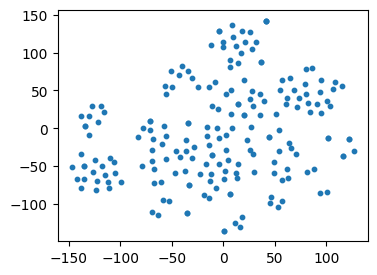

In [88]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(emb_right_tsne[:, 0], emb_right_tsne[:, 1], s=10)

In [91]:
def estimate_senses_aic(X, K_max=10):
    """
    X: (N_w × d) の文脈ベクトル行列
    K_max: 試すクラスタ数の最大値
    """
    best_aic, best_k = np.inf, 1
    for k in range(1, K_max+1):
        # sample_weight を使わずに GMM をフィット
        gmm = GaussianMixture(n_components=k, covariance_type='full')
        gmm.fit(X)
        aic = gmm.aic(X)      # AIC = 2·(#param) − 2·logL
        if aic < best_aic:
            best_aic, best_k = aic, k

    return best_k

In [92]:
best_k = estimate_senses_aic(embeddings_right, K_max=10)
print(best_k)

1


### BNCコーパスあれこれ

In [27]:
bnc_path = "/data/texts/english/bnc/processed/raw/"
files = os.listdir(bnc_path)

In [19]:
bnc_text = bnc_text.split("accession to corpus", maxsplit=1)[1]
bnc_text

" AIDS (Acquired Immune Deficiency Syndrome)  is a condition caused by a virus called HIV (Human Immuno Deficiency Virus).How is infection transmitted?through infected blood or blood products.It is not  transmitted from:How does it affect you?Often infected people are rejected by family and friends, leaving them to face this chronic condition alone.there is no vaccine or cure currently available.you can be infected for between 1015 years without realising it.women are twice as at risk from infection as men.16,000 reported infections (it is probable that there are between 4060,000 people actually infected).1 in 500 Londoners are believed to be infected.The World Health Organisation projects 40 million infections by the year 2000.The major impact is yet to come.Useful Contacts:Mildmay Hospital, Hackney Road, London E2 7NA  Hospice care  071 739 2331National AIDS Helpline  Counselling and confidential advice  0800 567 123Haemophilia Society  Serving the interests of Haemophiliacs  071 928

In [20]:
def parseText(text):

    NUM = 0
    nlp = init_parser("en_core_web_sm",
                      "spacy",
                      ext_names={"conll_pd": "pandas"},
                      conversion_maps={"deprel": {"nsubj": "subj"}})
    
    doc = nlp(text)

    result = ""
    sentence = []
    content = ""
    flag = True
    
    for val in doc._.pandas.values:
        
        if val[0] == 1 : 
            if flag == True: # Don't print out for the first time
                flag = False

            else:
                NUM+=1
                result += "\n\n# sent_id = "+ str(NUM) + "\n"
                result += "# text = "+" ".join(sentence) + "\n"
                result += content
            
                sentence = []       
                content = ""

         #if val[1] == "SPACE":
         #   continue
        
        content += "\t".join(map(str,val.tolist())) + "\n"
        sentence.append(val[1])
        
    if not flag:
        result += "\n\n# sent_id = "+ str(NUM) + "\n"
        result += "# text = "+" ".join(sentence) + "\n"
        result += content
        NUM += 1

        
    return result,NUM

In [21]:
#bnc_text = """AIDS (Acquired Immune Deficiency Syndrome)  is a condition caused by a virus called HIV (Human Immuno Deficiency Virus).How is infection transmitted?through infected blood or blood products.It is not  transmitted from:How does it affect you?Often infected people are rejected by family and friends, leaving them to face this chronic condition alone.there is no vaccine or cure currently available.you can be infected for between 1015 years without realising it.women are twice as at risk from infection as men.16,000 reported infections (it is probable that there are between 4060,000 people actually infected).1 in 500 Londoners are believed to be infected.The World Health Organisation projects 40 million infections by the year 2000.The major impact is yet to come.Useful Contacts:Mildmay Hospital, Hackney Road, London E2 7NA  Hospice care  071 739 2331National AIDS Helpline  Counselling and confidential advice  0800 567 123Haemophilia Society  Serving the interests of Haemophiliacs  071 928 2020Immunity  HIV and legal issues  081 968 8909Raising money for your favourite charity can be fun.There is no limit to the number of ways to raise money.Below I've listed some ideas which many people have already carried out.1. Why not have a clear out?It can be fun as well.JUMBLE SALEYou need to involve your friends collecting jumble.3."""
conll, num = parseText(bnc_text)

In [22]:
conll = pyconll.load.load_from_string(conll)
len(conll)

140